In [1]:
import os
import sys
from pathlib import Path
from collections import Counter, defaultdict
from functools import reduce
from typing import Optional, Union

import tqdm
import graphviz
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.axes import Axes



In [2]:
def load_npzs(data_dir: str):
    return [
        np.load(data_dir + "/" + str(f))
        for f in os.listdir(data_dir)
        if f.endswith(".npz")
    ]


def load_all_layouts(layout_dir: str):
    return {
        "ndt": load_npzs(layout_dir + "/nlp/default/train"),
        "nrt": load_npzs(layout_dir + "/nlp/random/train"),
        "xdt": load_npzs(layout_dir + "/xla/default/train"),
        "xrt": load_npzs(layout_dir + "/xla/random/train"),
    }

In [3]:
npzs = load_all_layouts(
    r"H:\data\pamr\predict-ai-model-runtime\npz_all\npz\layout"
)
npzs.keys()

dict_keys(['ndt', 'nrt', 'xdt', 'xrt'])

In [4]:
npzs["ndt"][0].files

['node_feat',
 'node_opcode',
 'edge_index',
 'node_config_feat',
 'node_config_ids',
 'config_runtime',
 'node_splits']

In [5]:
npzs["xdt"][0]["edge_index"].shape

(597, 2)

In [6]:
npzs["xdt"][0]["node_opcode"].shape

(372,)

### Symbol definitions

- $n$: number of nodes (i.e., tensor operations) in the graph.
- $m$: number of edges (i.e., tensor flows) in the graph.
- $c$: number of differenct configurations for the specific graph.
- $nc$: number of configurable nodes in the graph, must be less than or equal to n.

### Shape of features

- `node_feat`: ($n$, 140)
- `node_opcode`: ($n$,)
- `edge_index`: ($m$,)
- `node_config_feat`: ($c$, $nc$, 18)
- `node_config_ids`: ($nc$,)
- `config_runtime`: ($c$,)
- `node_splits`: variable length

## Draw model graph

In [7]:
import yaml

with open("../../data/node_name2id.yaml") as f:
    node_name2idx = yaml.load(f, Loader=yaml.FullLoader)

node_idx2name = {v: k for k, v in node_name2idx.items()}

In [8]:
model = npzs["xdt"][0]
model_name = model.fid.name.split("/")[-1].split(".")[0]

# Create a new directed graph
dot = graphviz.Digraph(model_name)

# Add nodes and edges to the graph
for edge in model["edge_index"]:
    dot.edge(str(edge[0]), str(edge[1]))

# Set configurable nodes to red
for node in model["node_config_ids"]:
    dot.node(str(node), fillcolor="red", style="filled")

# Set operation names as labels
for node, node_idx in enumerate(model["node_opcode"]):
    dot.node(str(node), label=node_idx2name[node_idx])

dot.render(f"../../output/{model_name}.gv", view=True)

'..\\..\\output\\alexnet_train_batch_32.gv.pdf'

## Configurable nodes

In [9]:
cfg_node_counter = defaultdict(int)

all_models = reduce(lambda x, y: x + y, npzs.values())
for model in tqdm.tqdm(all_models):
    c = Counter(
        [model["node_opcode"][node] for node in model["node_config_ids"]]
    )

    for k, v in c.items():
        cfg_node_counter[k] += v


100%|██████████| 535/535 [00:23<00:00, 22.76it/s]


In [10]:
cfg_node_counter = {node_idx2name[k]: v for k, v in cfg_node_counter.items()}
cfg_node_counter


{'reshape': 66003, 'dot': 98954, 'convolution': 20900}

All configurable nodes are "reshape", "dot" and "convolution", 
so it depends on the context of node rather then what it is.

## node_config_feat

In [11]:
model = all_models[0]
model_name = model.fid.name.split("/")[-1].split(".")[0]
print(f"Take model {model_name} as an example")

model["node_config_feat"].shape


Take model albert_en_base_batch_size_16_test as an example


(100040, 121, 18)

In [12]:
cfg_id2name = {
    0: "output_layout_0",
    1: "output_layout_1",
    2: "output_layout_2",
    3: "output_layout_3",
    4: "output_layout_4",
    5: "output_layout_5",
    6: "intput_layout_0",
    7: "intput_layout_1",
    8: "intput_layout_2",
    9: "intput_layout_3",
    10: "intput_layout_4",
    11: "intput_layout_5",
    12: "kernel_layout_0",
    13: "kernel_layout_1",
    14: "kernel_layout_2",
    15: "kernel_layout_3",
    16: "kernel_layout_4",
    17: "kernel_layout_5",
}

In [13]:
model["node_config_feat"].reshape(-1, 18)[:, 2]

array([-1., -1.,  0., ..., -1., -1., -1.], dtype=float32)

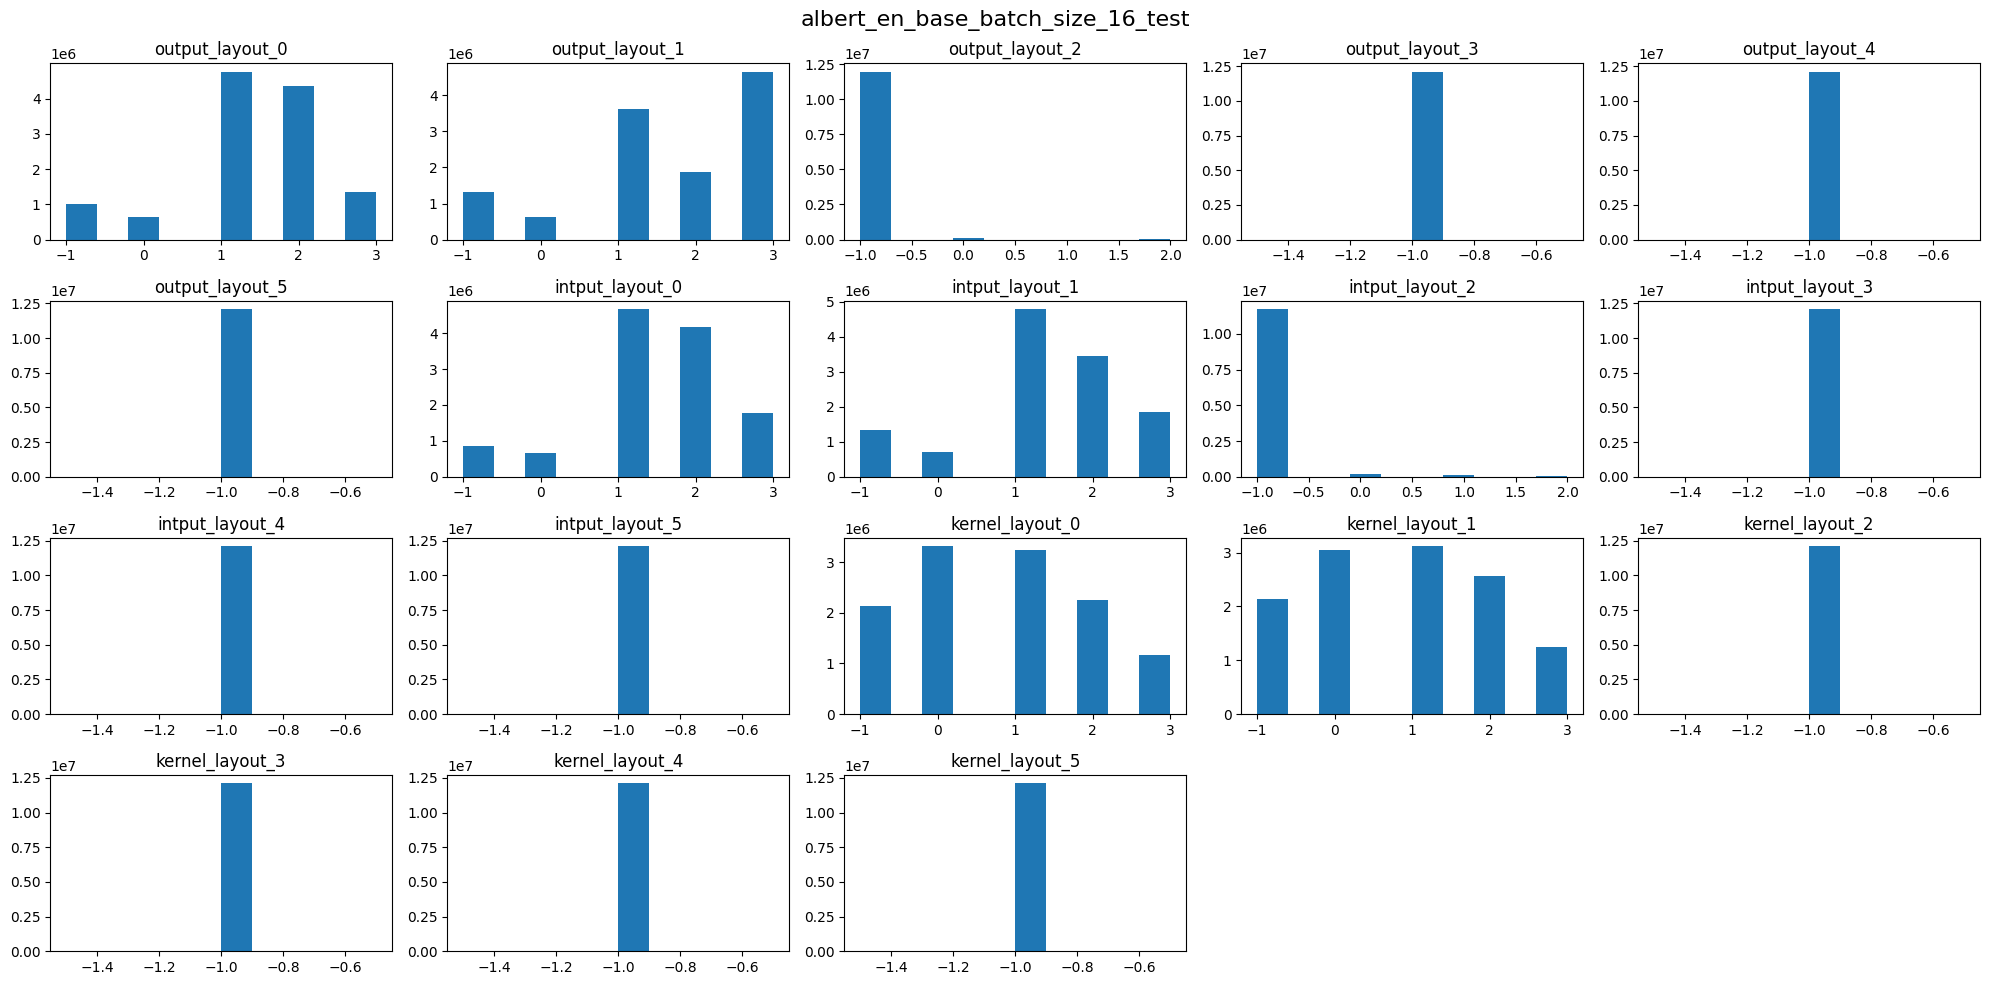

In [14]:

n = model["node_config_feat"].shape[-1]
fig, axes = plt.subplots(4, 5, figsize=(20, 10))

for i, ax in enumerate(axes.flatten()[:n]):
    ax.hist(model["node_config_feat"].reshape(-1, n)[:, i])
    ax.set_title(cfg_id2name[i])

for ax in axes.flatten()[n:]:
    ax.axis("off")

fig.suptitle(model_name, fontsize=16)
plt.tight_layout()

In [15]:
def plot_univar_dist(
    data: Union[pd.Series, np.ndarray],
    feature: str,
    bins: int = 250,
    ax: Optional[Axes] = None,
) -> None:
    """Plot univariate distribution.

    Parameters:
        data: univariate data to plot
        feature: feature name of the data
        bins: number of bins
        ax: user-specified axes

    Return:
        None
    """
    if isinstance(data, np.ndarray):
        data = pd.Series(data)

    if ax is None:
        fig, ax = plt.subplots(figsize=(24, 4))
    sns.histplot(data=data, bins=bins, kde=True, ax=ax)
    ax.axvline(
        x=data.mean(),
        color="orange",
        linestyle="dotted",
        linewidth=1.5,
        label="Mean",
    )
    ax.axvline(
        x=data.median(),
        color="green",
        linestyle="dotted",
        linewidth=1.5,
        label="Median",
    )
    ax.axvline(
        x=data.mode().values[0],
        color="red",
        linestyle="dotted",
        linewidth=1.5,
        label="Mode",
    )
    ax.set_title(
        f"{feature.upper()} Distibution\n"
        f"Min {round(data.min(), 2)} | "
        f"Max {round(data.max(), 2)} | "
        f"Skewness {round(data.skew(), 2)} | "
        f"Kurtosis {round(data.kurtosis(), 2)}"
    )
    ax.set_xticks(np.arange(5.4e6, 6e6, 1e4))
    
    ax.set_xlabel(f"{feature}")
    ax.set_ylabel("Bin Count")
    ax.legend()
    # if ax is None:
    #     plt.show()

c:\Users\ntj_0\Anaconda3\envs\gfos\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ntj_0\Anaconda3\envs\gfos\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


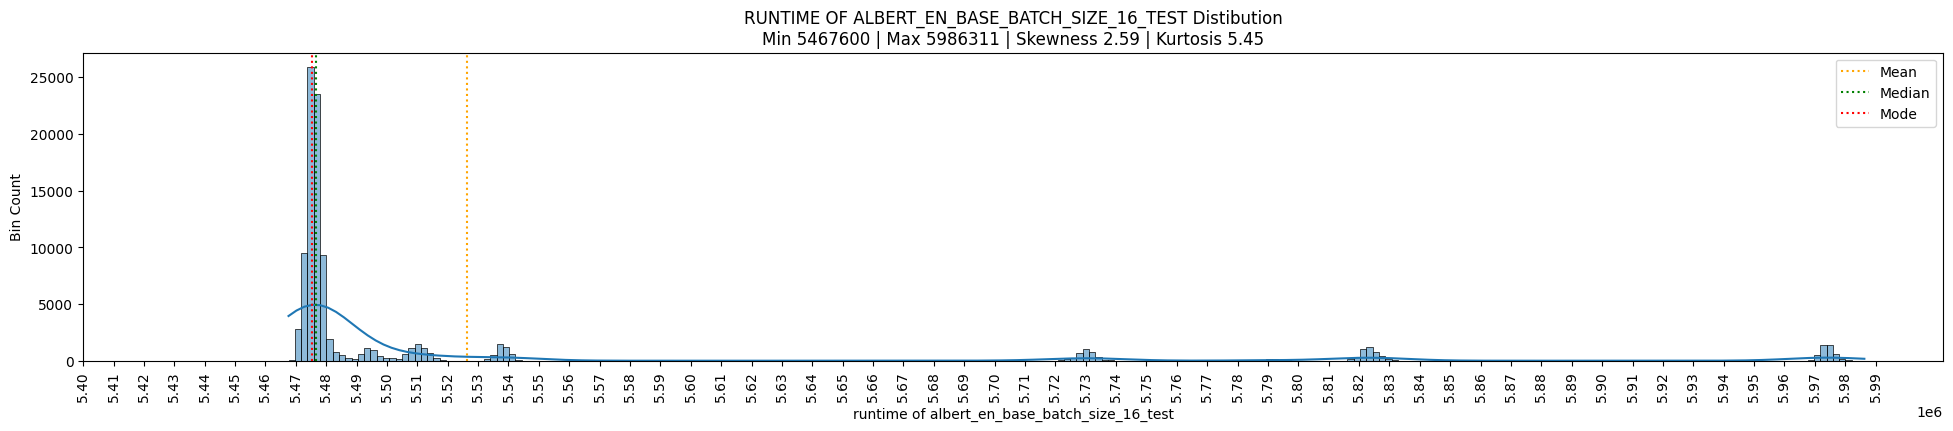

In [16]:
plot_univar_dist(model["config_runtime"], "runtime of " + model_name)
plt.xticks(rotation=90);

There are about 7 peeks, let's see the feature distributions of these peeks.

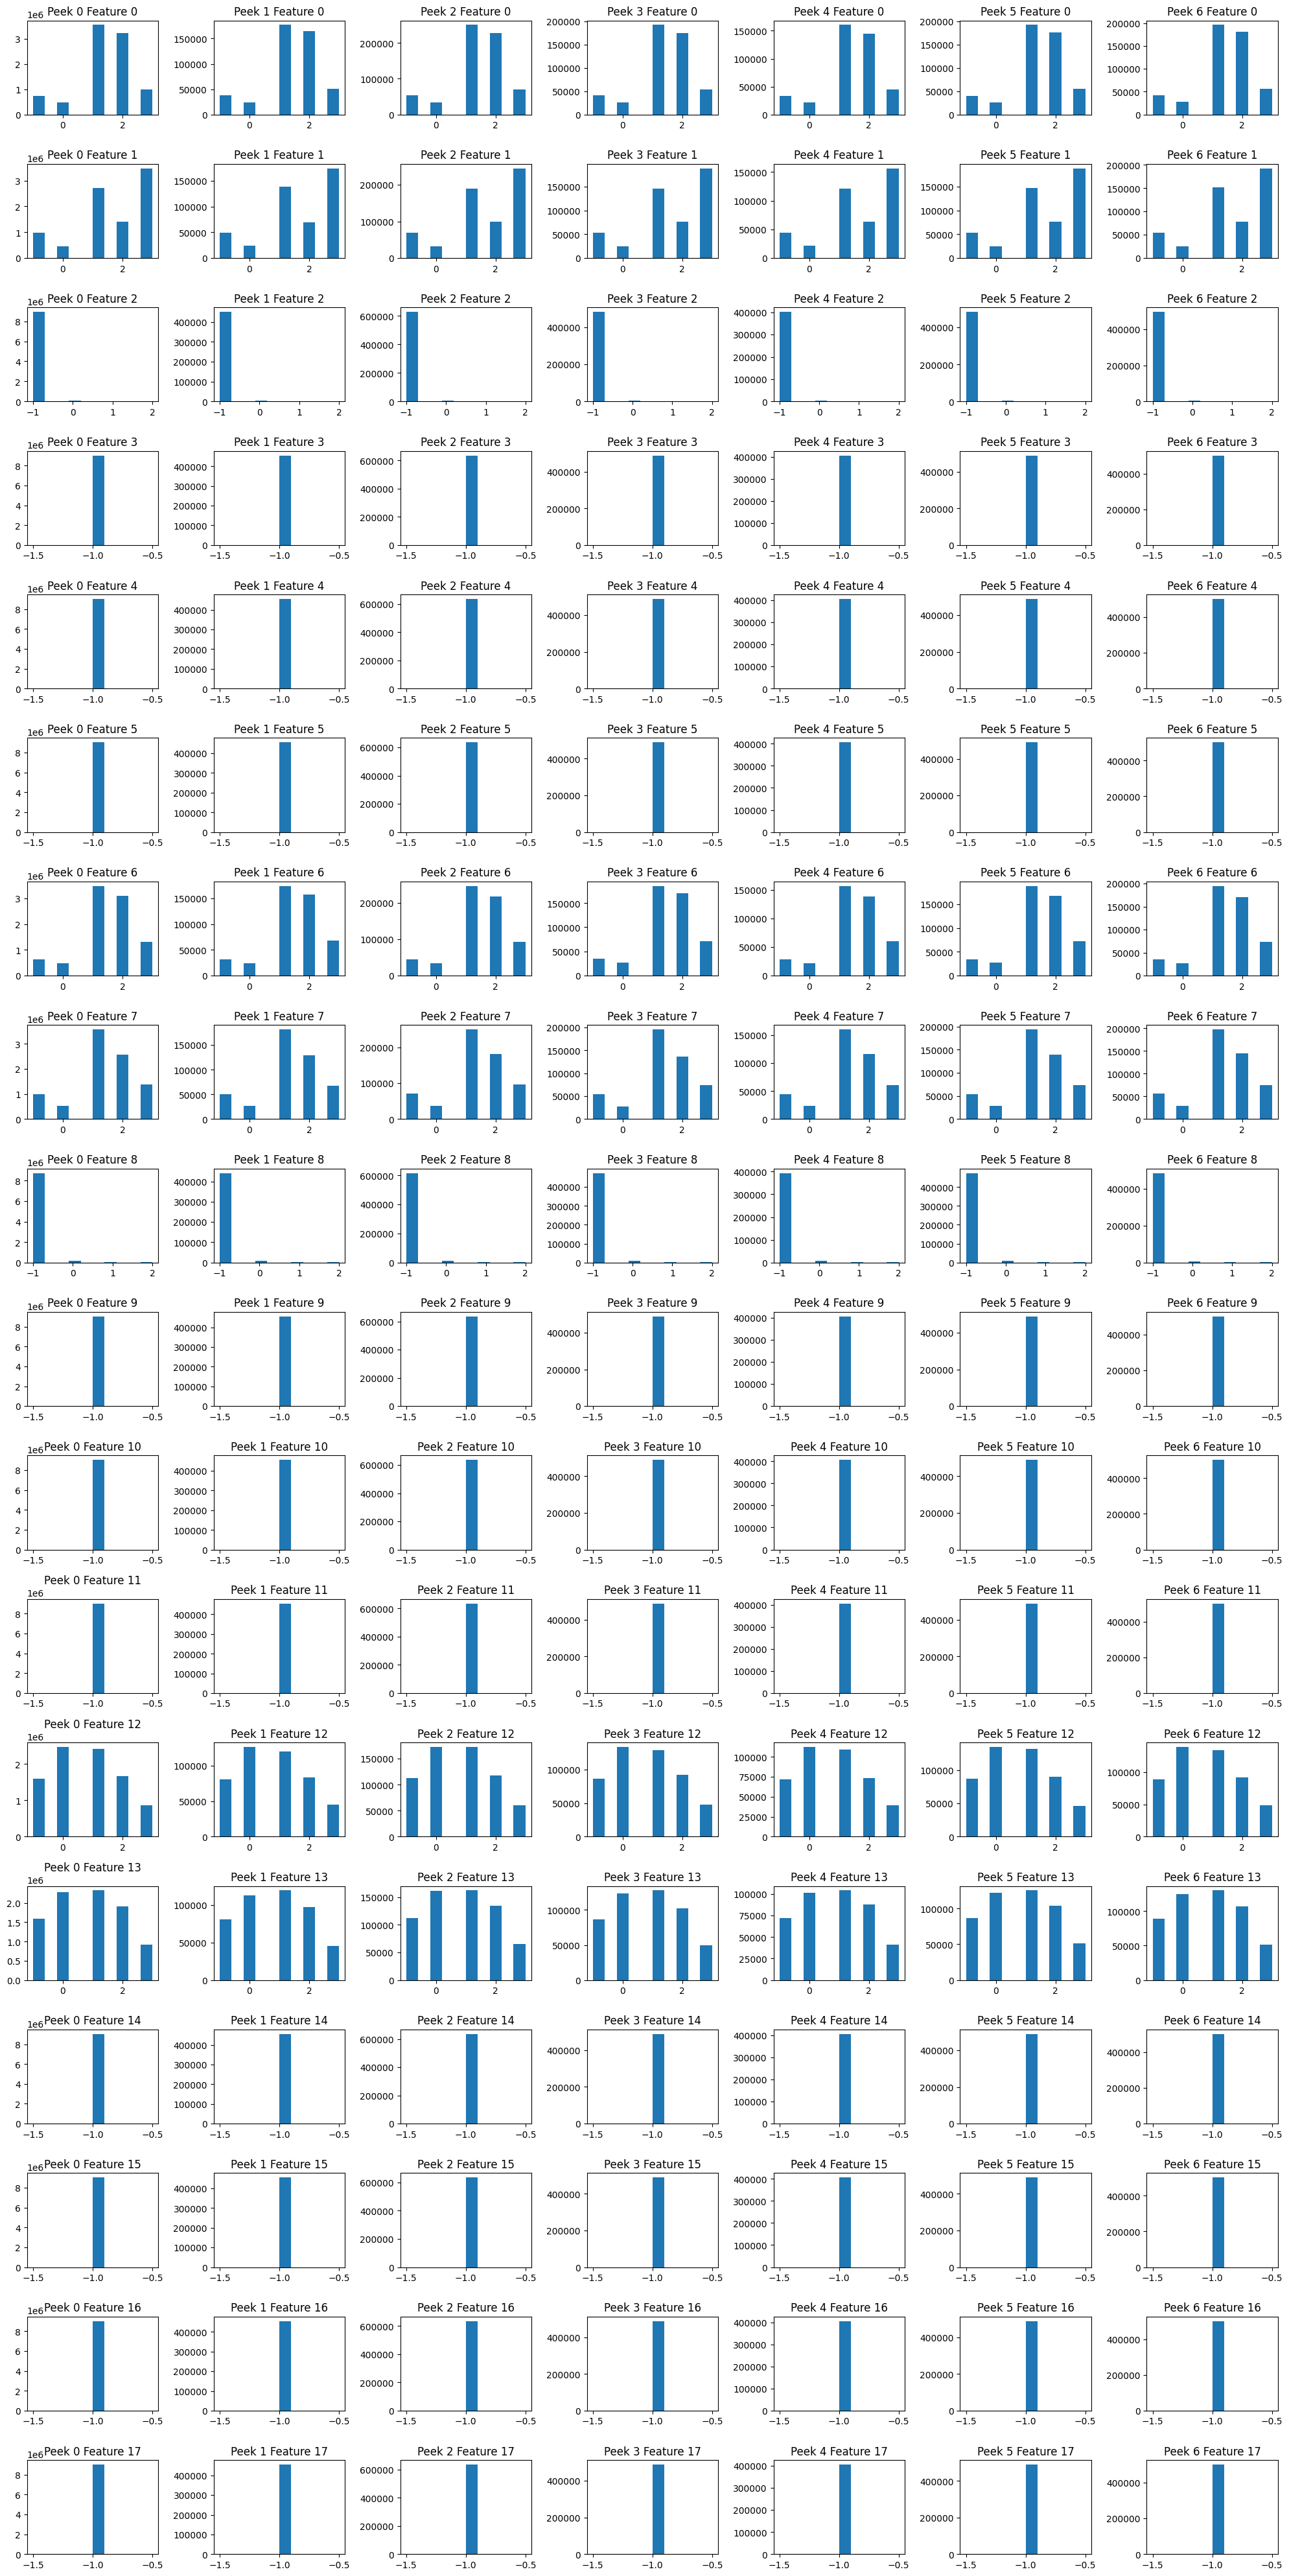

In [17]:
runtime = model["config_runtime"]
idx1 = np.where((runtime > 5470000) & (runtime < 5490000))[0]
idx2 = np.where((runtime > 5490000) & (runtime < 5505000))[0]
idx3 = np.where((runtime > 5505000) & (runtime < 5520000))[0]
idx4 = np.where((runtime > 5530000) & (runtime < 5550000))[0]
idx5 = np.where((runtime > 5720000) & (runtime < 5740000))[0]
idx6 = np.where((runtime > 5810000) & (runtime < 5840000))[0]
idx7 = np.where((runtime > 5960000) & (runtime < 6000000))[0]

indices = [idx1, idx2, idx3, idx4, idx5, idx6, idx7]
axes = plt.subplots(18, 7, figsize=(20, 40))[1]

for f in range(n):
    for i in range(len(indices)):
        axes[f, i].hist(model["node_config_feat"][indices[i]].reshape(-1, 18)[:, f])
        axes[f, i].set_title(f"Peek {i} Feature {f}")

plt.tight_layout()

seems the distributions did't change so much even if the runtime is different.